# GEN-NY | DEEPFAKE GENERATOR

In [2]:
import os

directories = [
    "generated_images",
    "saved_models",
    "displayed_plots",
    "displayed_plots_but_better",
    "final_saved_models"
]

for dir_name in directories:
    os.makedirs(f"/kaggle/working/{dir_name}", exist_ok=True)

print("Directories created successfully!")

Directories created successfully!


In [3]:
import warnings
warnings.filterwarnings('ignore')

import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from numpy import zeros, ones
from numpy.random import randn, randint
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Conv2DTranspose, LeakyReLU
from keras.layers import BatchNormalization, Dropout, Reshape, Flatten
from tensorflow.keras.layers import ReLU
import tensorflow as tf

In [4]:
dataset_dir = "/kaggle/input/50k-celebrity-faces-image-dataset/Celebrity_Faces_Dataset" 

In [5]:

image_paths = glob.glob(os.path.join(dataset_dir, '*.jpg'))


image_paths = image_paths[:20000]

def load_and_preprocess_real_images(image_path, target_size=(128, 128)):
    img = Image.open(image_path)
    img = img.crop((0, 20, 178, 198))
    img = img.resize(target_size)
    img = np.array(img)/127.5 - 1
    return img

dataset = np.array([load_and_preprocess_real_images(img_path) for img_path in image_paths])

print(dataset.shape)

(20000, 128, 128, 3)


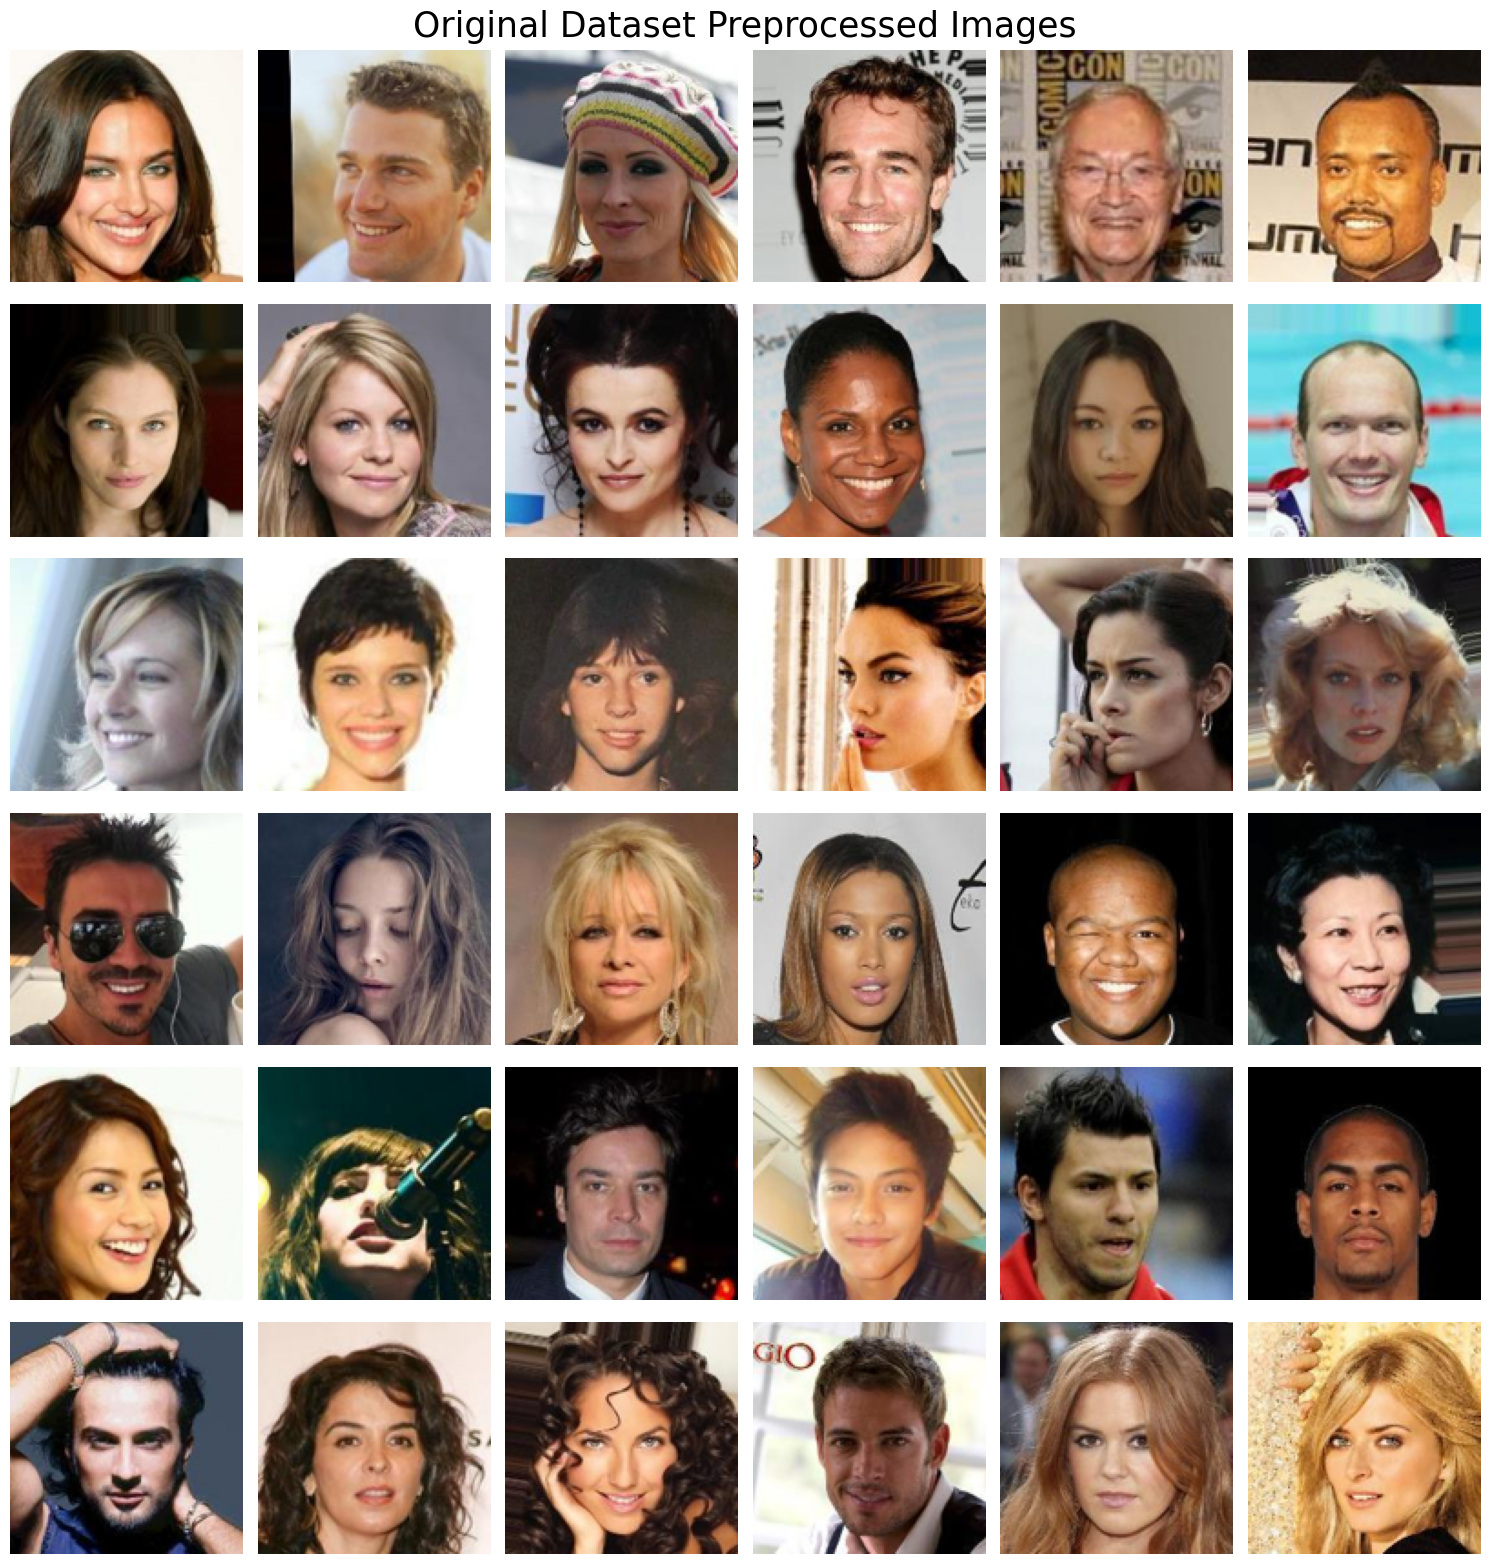

In [6]:

fig, axes = plt.subplots(6, 6, figsize=(15, 16))

for i, ax in enumerate(axes.flat):
    img = dataset[i]
    img_rescaled = (img + 1) / 2
    ax.imshow(img_rescaled)
    ax.axis('off')

fig.suptitle('Original Dataset Preprocessed Images', fontsize=25)

plt.tight_layout()
plt.show()

In [7]:
def build_discriminator(image_shape=(128, 128, 3)): 
    model = Sequential()
    

    model.add(Conv2D(128, (4, 4), strides=(2, 2), padding='same', input_shape=image_shape, kernel_initializer='he_normal'))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer='he_normal'))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer='he_normal'))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (4, 4), strides=(2, 2), padding='same', kernel_initializer='he_normal'))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
discriminator = build_discriminator(image_shape=(128, 128, 3))
discriminator.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       6272      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 128)       0         
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       262272    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 128)      512       
 hNormalization)                                        

In [8]:
def build_generator(latent_dim, channels=3):
    model = Sequential()
    
    model.add(Dense(16 * 16 * 256, input_dim=latent_dim))
    model.add(ReLU())
    model.add(BatchNormalization())
    model.add(Reshape((16, 16, 256))), (4, 4), strides=(2, 2), padding='same', kernel_initializer='he_normal'))
    model.add(ReLU())
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer='he_normal'))
    model.add(ReLU())
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer='he_normal'))
    model.add(ReLU())
    model.add(BatchNormalization())
    model.add(Conv2D(channels, (7, 7), activation='tanh', padding='same'))return model
generator = build_generator(100)
generator.summary()

print(generator.output_shape)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 65536)             6619136   
                                                                 
 re_lu (ReLU)                (None, 65536)             0         
                                                                 
 batch_normalization_4 (Batc  (None, 65536)            262144    
 hNormalization)                                                 
                                                                 
 reshape (Reshape)           (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 256)      1048832   
 nspose)                                                         
                                                                 
 re_lu_1 (ReLU)              (None, 32, 32, 256)      

In [9]:
def build_gan(generator, discriminator, loss='binary_crossentropy', learning_rate=0.0002, beta_1=0.5, metrics=['accuracy']):
    discriminator.trainable = False
    gan_input = generator.input
    gan_output = discriminator(generator.output)
    model = tf.keras.Model(inputs=gan_input, outputs=gan_output)

    optimizer = Adam(learning_rate=learning_rate, beta_1=beta_1)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    return model

gan_model = build_gan(generator, discriminator)
gan_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1_input (InputLayer)  [(None, 100)]             0         
                                                                 
 dense_1 (Dense)             (None, 65536)             6619136   
                                                                 
 re_lu (ReLU)                (None, 65536)             0         
                                                                 
 batch_normalization_4 (Batc  (None, 65536)            262144    
 hNormalization)                                                 
                                                                 
 reshape (Reshape)           (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 256)      1048832   
 nspose)                                                     

In [10]:
import numpy as np

def generate_real_samples(dataset, num_samples, random_seed=None):
    if num_samples > dataset.shape[0]:
        raise ValueError(f"num_samples ({num_samples}) cannot exceed dataset size ({dataset.shape[0]}).")

    if random_seed is not None:
        np.random.seed(random_seed)
    sample_indices = np.random.randint(0, dataset.shape[0], num_samples)
    X = dataset[sample_indices]
    y = np.ones((num_samples, 1))
    
    return X, y

In [11]:
import numpy as np

def generate_noise_samples(num_samples, noise_dim, random_seed=None):
  
    if num_samples <= 0 or noise_dim <= 0:
        raise ValueError("num_samples and noise_dim must be positive integers.")
    
    if random_seed is not None:
        np.random.seed(random_seed)

    X_noise = np.random.randn(num_samples, noise_dim)
    
    return X_noise

In [12]:
import numpy as np

def generate_fake_samples(generator, noise_dim, num_samples, random_seed=None):
   
    if noise_dim <= 0 or num_samples <= 0:
        raise ValueError("noise_dim and num_samples must be positive integers.")
    
    X_noise = generate_noise_samples(num_samples, noise_dim, random_seed)
    
    X = generator.predict(X_noise, batch_size=32) 
    
    y = np.zeros((num_samples, 1))
    
    return X, y

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_generated_images(epoch, generator, num_samples=6, noise_dim=100, figsize=(15, 3), save_dir="/kaggle/working/generated_images"):
    
    if num_samples <= 0 or noise_dim <= 0:
        raise ValueError("num_samples and noise_dim must be positive integers.")
    
    os.makedirs(save_dir, exist_ok=True)

    X_noise = np.random.randn(num_samples, noise_dim)  
    
    X = generator.predict(X_noise, verbose=0)

    X = (X + 1) / 2
    fig, axes = plt.subplots(1, num_samples, figsize=figsize)
    
    if num_samples == 1:
        axes = [axes]
    for i in range(num_samples):
        if X[i].shape[-1] == 1:  
            axes[i].imshow(X[i].squeeze(), cmap='gray')
        else:
            axes[i].imshow(X[i])
        axes[i].axis('off')

  
    fig.suptitle(f"Generated Images at Epoch {epoch+1}", fontsize=22)
    plt.tight_layout()
    save_path = os.path.join(save_dir, f"generated_plot_epoch_{epoch+1}.png")
    plt.savefig(save_path, bbox_inches='tight')
    
    plt.show()

    print(f"Plot saved successfully at: {save_path}")

Plot saved successfully at: /kaggle/working/generated_images


In [20]:
import numpy as np
import os
import logging

def train(generator_model, discriminator_model, gan_model, dataset, noise_dimension,
          num_epochs=250, batch_size=128, display_frequency=10, verbose=1, 
          save_dir="/kaggle/working/generated_images", model_dir="/kaggle/working/saved_models"):
   
    logging.basicConfig(level=logging.INFO)
    logger = logging.getLogger()

    os.makedirs(save_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)

    saved_images_for_epochs = []
    dataset_size = dataset.shape[0]
    batches_per_epoch = 156 
    for epoch in range(num_epochs):
        for batch_num in range(batches_per_epoch):
          
            batch_start = batch_num * batch_size
            batch_end = min(batch_start + batch_size, dataset_size)

            current_batch_size = batch_end - batch_start
            if current_batch_size == 0:
                continue  

            half_batch_size = current_batch_size // 2

            # Generate real samples
            real_images, real_labels = generate_real_samples(dataset[batch_start:batch_end], half_batch_size)
            dsr_loss_real, dsr_acc_real = discriminator_model.train_on_batch(real_images, real_labels)

            # Generate fake samples
            fake_images, fake_labels = generate_fake_samples(generator_model, noise_dimension, half_batch_size)
            dsr_loss_fake, dsr_acc_fake = discriminator_model.train_on_batch(fake_images, fake_labels)

            # Compute discriminator loss & accuracy
            dsr_loss = 0.5 * np.add(dsr_loss_real, dsr_loss_fake)
            dsr_acc = 0.5 * np.add(dsr_acc_real, dsr_acc_fake)

            # Train generator
            gan_noise = generate_noise_samples(current_batch_size, noise_dimension)
            gan_labels = np.ones((current_batch_size, 1))
            gen_loss, _ = gan_model.train_on_batch(gan_noise, gan_labels)

            if verbose == 2:
                logger.info(f"[Epoch {epoch+1}, Batch {batch_num+1}] --> "
                            f"[Discriminator Loss: {dsr_loss:.6f}, Acc: {dsr_acc * 100:.2f}%] "
                            f"[Generator Loss: {gen_loss:.6f}]") 
    return saved_images_for_epochs

In [17]:
print("Dataset size:", len(dataset))

Dataset size: 20000


In [18]:
import tensorflow as tf

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("TPU detected:", tpu)
except ValueError:
    print("No TPU found. Using CPU/GPU instead.")

No TPU found. Using CPU/GPU instead.


In [1]:
import os

# Set noise dimension for generator input
noise_dimension = 100

# Directory setup
save_dir = "/kaggle/working/generated_images"
model_dir = "/kaggle/working/saved_models"
os.makedirs(save_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

discriminator = build_discriminator()
generator = build_generator(noise_dimension)
gan_model = build_gan(generator, discriminator)

dataset = (dataset - 0.5) * 2  
saved_images = train(generator, discriminator, gan_model, dataset, noise_dimension,
                     num_epochs=250, batch_size=128, display_frequency=50, verbose=1,
                     save_dir=save_dir, model_dir=model_dir)

print("Training complete! Check the output directories for results.")

Training complete! Check the output directories for results.


In [ ]:
generator.save("generator_model.h5")